## Knowdlege Graphs

We can run graph algorithms and calculate the centralities for any node, to understand how important a concept (node) is to the body of work. We can understand links between seemingly disconnected concepts.

## GRAG ( Graph Retrieval Augmented Generation)

We can also use knowledge graphs to implement Graph Retrieval Augmented Generation (GRAG or GAG) and chat with our documents. This can give us much better results than the plain old version of RAG, which suffers several shortcomings. For example, retrieving the context that is the most relevant for the query with a simple semantic similarity search is not always effective. Especially, when the query does not provide enough context about its true intent, or when the context is fragments across a large corpus of text.

### Create graph of concepts

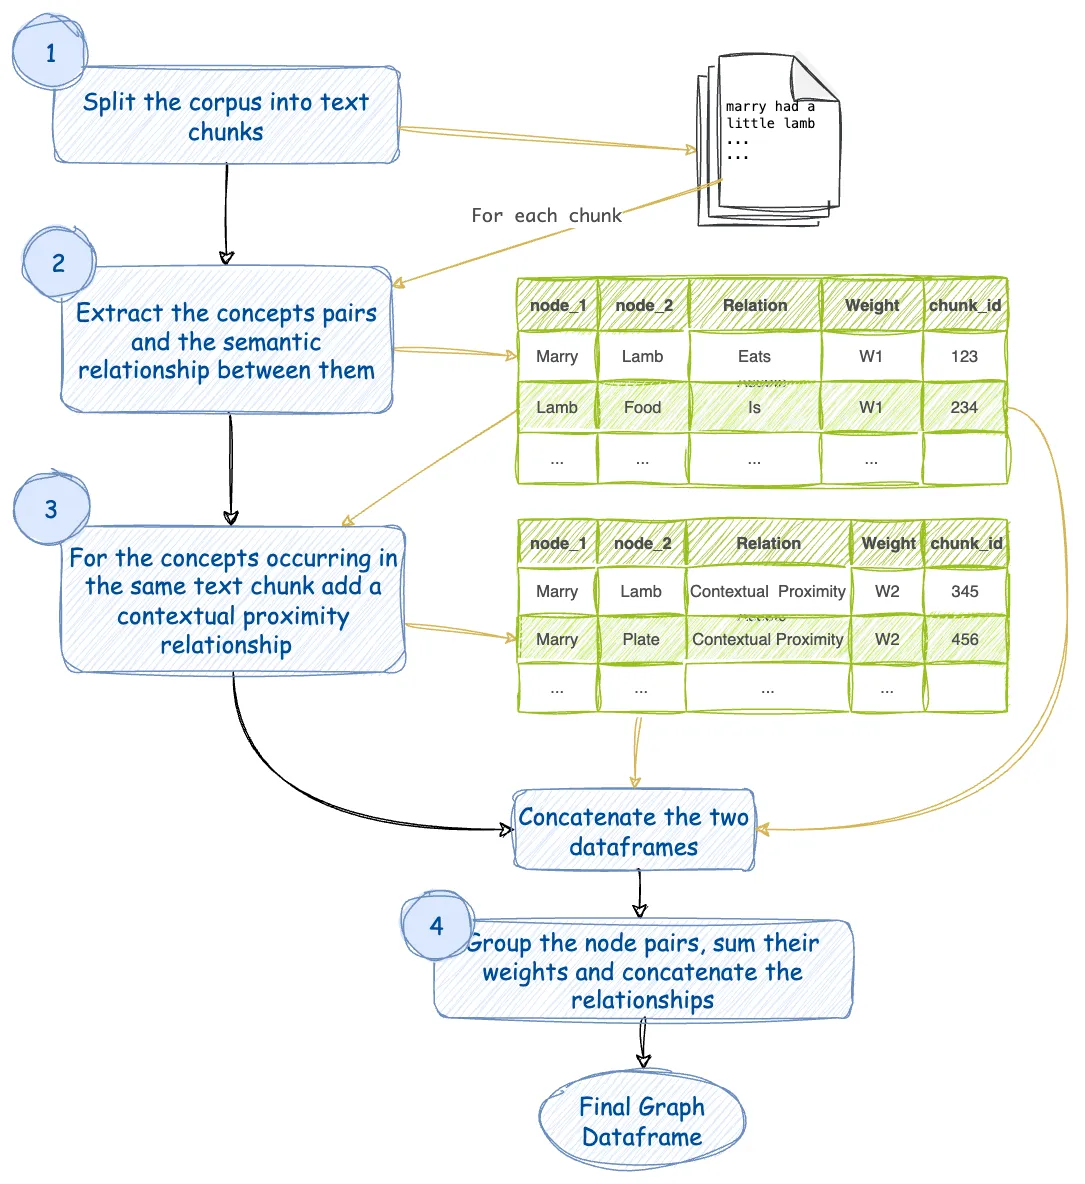

In [1]:
!pip install pypdf langchain  pydantic yachalk networkx seaborn pyvis -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import ipywidgets as widgets
from IPython.display import display
import tempfile
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel



def process_pdf(file_info):
    if not file_info:
        print("No file uploaded")
        return

    # Extract the first item in the tuple which is the file information dictionary
    file_info_dict = file_info[0]

    # Extract the content of the uploaded file
    uploaded_file_content = file_info_dict['content']

    pdf_path = ""
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as temp_file:
        temp_file.write(uploaded_file_content)
        pdf_path = temp_file.name

    if pdf_path == "":
        print("File upload error")
        return

    loader = PyPDFLoader(pdf_path)
    documents=loader.load()
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500,
        chunk_overlap=150,
        length_function=len,
        is_separator_regex=False,
    )
    pages = splitter.split_documents(documents)
    print("Number of chunks = ", len(pages))
    print("First page content: ",pages[0].page_content)
    return pages


upload_button = widgets.FileUpload(
    accept='.pdf',  # Accept only .pdf files
    multiple=False  # Allow only one file to be uploaded
)

process_button = widgets.Button(description="Process PDF")


display(upload_button)

FileUpload(value=(), accept='.pdf', description='Upload')

In [3]:
pages=process_pdf(upload_button.value)

Number of chunks =  12
First page content:  Rowdy
offers:
●
Sweaters
These
sweaters
are
one
of
the
finest
in
the
ski
industry.
We
provide
different
types
of
them:
○
Relaxed
Turtleneck:
Introducing
the
Relaxed
Turtleneck
Sweater
–
a
perfect
fusion
of
comfort
and
style
to
keep
you
warm
and
chic
throughout
the
winter
season.
Whether
you're
heading
out
for
a
casual
day
or
a
sophisticated
evening,
this
sweater
is
designed
to
elevate
your
winter
wardrobe
with
its
cosy ,
relaxed
fit.
■
Gender:
Woman
■
Color:
Indigo
or
Gray
■
Size:
XS,
S,
M,
L,
XL
■
Key
features:
●
Cozy
Comfort:
Immerse
yourself
in
the
luxurious
warmth
of
the
relaxed
turtleneck
design.
The
soft
and
plush
fabric
provides
a
cocoon
of
comfort,
making
it
an
ideal
choice
for
chilly
days
and
evenings.
●
Effortless
Style:
Embrace
a
laid-back
yet
sophisticated
look
with
the
relaxed
fit
and
timeless
turtleneck
design.
Effortlessly
pair
it
with
your
favorite
jeans
for
a
casual
outing
or
dress
it
up
with
tailored
pants
for
a
more
polishe

![graph_method.webp](./resources/Ollama.webp)

# Ollama  🦙🦙

In [4]:
import os
import json
import requests

In [5]:
## Set Url Where Ollama runs
BASE_URL = os.environ.get('OLLAMA_HOST', 'http://localhost:11434')

In [6]:
# Generate a response for a given prompt with a provided model. This is a streaming endpoint, so will be a series of responses.
# The final response object will include statistics and additional data from the request. Use the callback function to override
# the default handler.
def generate(model_name, prompt, system=None, template=None, context=None, options=None, callback=None):
    try:
        url = f"{BASE_URL}/api/generate"
        payload = {
            "model": model_name, 
            "prompt": prompt, 
            "system": system, 
            "template": template, 
            "context": context, 
            "options": options
        }
        
        # Remove keys with None values
        payload = {k: v for k, v in payload.items() if v is not None}
        
        with requests.post(url, json=payload, stream=True) as response:
            response.raise_for_status()
            
            # Creating a variable to hold the context history of the final chunk
            final_context = None
            
            # Variable to hold concatenated response strings if no callback is provided
            full_response = ""

            # Iterating over the response line by line and displaying the details
            for line in response.iter_lines():
                if line:
                    # Parsing each line (JSON chunk) and extracting the details
                    chunk = json.loads(line)
                    
                    # If a callback function is provided, call it with the chunk
                    if callback:
                        callback(chunk)
                    else:
                        # If this is not the last chunk, add the "response" field value to full_response and print it
                        if not chunk.get("done"):
                            response_piece = chunk.get("response", "")
                            full_response += response_piece
                            print(response_piece, end="", flush=True)
                    
                    # Check if it's the last chunk (done is true)
                    if chunk.get("done"):
                        final_context = chunk.get("context")
            
            # Return the full response and the final context
            return full_response, final_context
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None, None

# Create a model from a Modelfile. Use the callback function to override the default handler.
def create(model_name, model_path, callback=None):
    try:
        url = f"{BASE_URL}/api/create"
        payload = {"name": model_name, "path": model_path}
        
        # Making a POST request with the stream parameter set to True to handle streaming responses
        with requests.post(url, json=payload, stream=True) as response:
            response.raise_for_status()

            # Iterating over the response line by line and displaying the status
            for line in response.iter_lines():
                if line:
                    # Parsing each line (JSON chunk) and extracting the status
                    chunk = json.loads(line)

                    if callback:
                        callback(chunk)
                    else:
                        print(f"Status: {chunk.get('status')}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

# Pull a model from a the model registry. Cancelled pulls are resumed from where they left off, and multiple
# calls to will share the same download progress. Use the callback function to override the default handler.
def pull(model_name, insecure=False, callback=None):
    try:
        url = f"{BASE_URL}/api/pull"
        payload = {
            "name": model_name,
            "insecure": insecure
        }

        # Making a POST request with the stream parameter set to True to handle streaming responses
        with requests.post(url, json=payload, stream=True) as response:
            response.raise_for_status()

            # Iterating over the response line by line and displaying the details
            for line in response.iter_lines():
                if line:
                    # Parsing each line (JSON chunk) and extracting the details
                    chunk = json.loads(line)

                    # If a callback function is provided, call it with the chunk
                    if callback:
                        callback(chunk)
                    else:
                        # Print the status message directly to the console
                        print(chunk.get('status', ''), end='', flush=True)
                    
                    # If there's layer data, you might also want to print that (adjust as necessary)
                    if 'digest' in chunk:
                        print(f" - Digest: {chunk['digest']}", end='', flush=True)
                        print(f" - Total: {chunk['total']}", end='', flush=True)
                        print(f" - Completed: {chunk['completed']}", end='\n', flush=True)
                    else:
                        print()
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

# Push a model to the model registry. Use the callback function to override the default handler.
def push(model_name, insecure=False, callback=None):
    try:
        url = f"{BASE_URL}/api/push"
        payload = {
            "name": model_name,
            "insecure": insecure
        }

        # Making a POST request with the stream parameter set to True to handle streaming responses
        with requests.post(url, json=payload, stream=True) as response:
            response.raise_for_status()

            # Iterating over the response line by line and displaying the details
            for line in response.iter_lines():
                if line:
                    # Parsing each line (JSON chunk) and extracting the details
                    chunk = json.loads(line)

                    # If a callback function is provided, call it with the chunk
                    if callback:
                        callback(chunk)
                    else:
                        # Print the status message directly to the console
                        print(chunk.get('status', ''), end='', flush=True)
                    
                    # If there's layer data, you might also want to print that (adjust as necessary)
                    if 'digest' in chunk:
                        print(f" - Digest: {chunk['digest']}", end='', flush=True)
                        print(f" - Total: {chunk['total']}", end='', flush=True)
                        print(f" - Completed: {chunk['completed']}", end='\n', flush=True)
                    else:
                        print()
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

# List models that are available locally.
def list():
    try:
        response = requests.get(f"{BASE_URL}/api/tags")
        response.raise_for_status()
        data = response.json()
        models = data.get('models', [])
        return models

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

# Copy a model. Creates a model with another name from an existing model.
def copy(source, destination):
    try:
        # Create the JSON payload
        payload = {
            "source": source,
            "destination": destination
        }
        
        response = requests.post(f"{BASE_URL}/api/copy", json=payload)
        response.raise_for_status()
        
        # If the request was successful, return a message indicating that the copy was successful
        return "Copy successful"

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

# Delete a model and its data.
def delete(model_name):
    try:
        url = f"{BASE_URL}/api/delete"
        payload = {"name": model_name}
        response = requests.delete(url, json=payload)
        response.raise_for_status()
        return "Delete successful"
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

# Show info about a model.
def show(model_name):
    try:
        url = f"{BASE_URL}/api/show"
        payload = {"name": model_name}
        response = requests.post(url, json=payload)
        response.raise_for_status()
        
        # Parse the JSON response and return it
        data = response.json()
        return data
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

def heartbeat():
    try:
        url = f"{BASE_URL}/"
        response = requests.head(url)
        response.raise_for_status()
        return "Ollama is running"
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return "Ollama is not running"

### Dataframe of all chunks from PDF

In [7]:
import sys
from yachalk import chalk
sys.path.append("..")

import json


### Define some functions to generate  graph & concepts (these are just prompts for the model)
def graphPrompt(input: str, metadata={}, model="mistral-openorca:latest"):
    if model == None:
        model = "mistral-openorca:latest"

    ### Custom prompt for mistral to generate graph
    SYS_PROMPT = (
        "You are a network graph maker who extracts terms and their relations from a given context. "
        "You are provided with a context chunk (delimited by ```) Your task is to extract the ontology "
        "of terms mentioned in the given context. These terms should represent the key concepts as per the context. \n"
        "Thought 1: While traversing through each sentence, Think about the key terms mentioned in it.\n"
            "\tTerms may include object, entity, location, organization, person, \n"
            "\tcondition, acronym, documents, service, concept, etc.\n"
            "\tTerms should be as atomistic as possible\n\n"
        "Thought 2: Think about how these terms can have one on one relation with other terms.\n"
            "\tTerms that are mentioned in the same sentence or the same paragraph are typically related to each other.\n"
            "\tTerms can be related to many other terms\n\n"
        "Thought 3: Find out the relation between each such related pair of terms. \n\n"
        "Format your output as a list of json. Each element of the list contains a pair of terms"
        "and the relation between them, like the follwing: \n"
        "[\n"
        "   {\n"
        '       "node_1": "A concept from extracted ontology",\n'
        '       "node_2": "A related concept from extracted ontology",\n'
        '       "edge": "relationship between the two concepts, node_1 and node_2 in one or two sentences"\n'
        "   }, {...}\n"
        "]"
    )

    USER_PROMPT = f"context: ```{input}``` \n\n output: "
    response, _ = generate(model_name=model, system=SYS_PROMPT, prompt=USER_PROMPT)
    try:
        result = json.loads(response)
        result = [dict(item, **metadata) for item in result]
    except:
        print("\n\nERROR ### Here is the buggy response: ", response, "\n\n")
        result = None
    return result


def extractConcepts(prompt: str, metadata={}, model="mistral-openorca:latest"):
    SYS_PROMPT = (
        "Your task is extract the key concepts (and non personal entities) mentioned in the given context. "
        "Extract only the most important and atomistic concepts, if  needed break the concepts down to the simpler concepts."
        "Categorize the concepts in one of the following categories: "
        "[event, concept, place, object, document, organisation, condition, misc]\n"
        "Format your output as a list of json with the following format:\n"
        "[\n"
        "   {\n"
        '       "entity": The Concept,\n'
        '       "importance": The concontextual importance of the concept on a scale of 1 to 5 (5 being the highest),\n'
        '       "category": The Type of Concept,\n'
        "   }, \n"
        "{ }, \n"
        "]\n"
    )
    response, _ = generate(model_name=model, system=SYS_PROMPT, prompt=prompt)
    try:
        result = json.loads(response)
        result = [dict(item, **metadata) for item in result]
    except:
        print("\n\nERROR ### Here is the buggy response: ", response, "\n\n")
        result = None
    return result

In [8]:
import uuid
import pandas as pd
import numpy as np

### Helpers functions


### Turns a PDF to a Pandas Dataframe
def documents2Dataframe(documents) -> pd.DataFrame:
    rows = []
    for chunk in documents:
        row = {
            "text": chunk.page_content,
            **chunk.metadata,
            "chunk_id": uuid.uuid4().hex,
        }
        rows = rows + [row]

    df = pd.DataFrame(rows)
    return df

def df2ConceptsList(dataframe: pd.DataFrame) -> list:
    # dataframe.reset_index(inplace=True)
    results = dataframe.apply(
        lambda row: extractConcepts(
            row.text, {"chunk_id": row.chunk_id, "type": "concept"}
        ),
        axis=1,
    )
    # invalid json results in NaN
    results = results.dropna()
    results = results.reset_index(drop=True)

    ## Flatten the list of lists to one single list of entities.
    concept_list = np.concatenate(results).ravel().tolist()
    return concept_list


def concepts2Df(concepts_list) -> pd.DataFrame:
    ## Remove all NaN entities
    concepts_dataframe = pd.DataFrame(concepts_list).replace(" ", np.nan)
    concepts_dataframe = concepts_dataframe.dropna(subset=["entity"])
    concepts_dataframe["entity"] = concepts_dataframe["entity"].apply(
        lambda x: x.lower()
    )

    return concepts_dataframe


def df2Graph(dataframe: pd.DataFrame, model=None) -> list:
    # dataframe.reset_index(inplace=True)
    results = dataframe.apply(
        lambda row: graphPrompt(row.text, {"chunk_id": row.chunk_id}, model), axis=1
    )
    # invalid json results in NaN
    results = results.dropna()
    results = results.reset_index(drop=True)

    ## Flatten the list of lists to one single list of entities.
    concept_list = np.concatenate(results).ravel().tolist()
    return concept_list


def graph2Df(nodes_list) -> pd.DataFrame:
    ## Remove all NaN entities
    graph_dataframe = pd.DataFrame(nodes_list).replace(" ", np.nan)
    graph_dataframe = graph_dataframe.dropna(subset=["node_1", "node_2"])
    graph_dataframe["node_1"] = graph_dataframe["node_1"].apply(lambda x: x.lower())
    graph_dataframe["node_2"] = graph_dataframe["node_2"].apply(lambda x: x.lower())

    return graph_dataframe

In [9]:
## Here we convert the PDF to a dataframe
df = documents2Dataframe(pages)
print(df.shape)
df.head()

(12, 4)


,text,source,page,chunk_id
0,Rowdy\noffers:\n●\nSweaters\nThese\nsweaters\n...,/var/folders/8m/mnbbj_z14sd5qml35sxykmdh0000gn...,0,e33dea31b44e48ca841e38c3550ca20f
1,"ensure\nlongevity ,\nmaking\nit\na\nreliable\n...",/var/folders/8m/mnbbj_z14sd5qml35sxykmdh0000gn...,0,a3d798ffc654458bb5694707b72c9c17
2,●\nWrap\nyourself\nin\nthe\ncozy\nelegance\nof...,/var/folders/8m/mnbbj_z14sd5qml35sxykmdh0000gn...,1,80d2489045d94392ad2e0e711b0db998
3,An\ninvestment\nthat\nstands\nthe\ntest\nof\nt...,/var/folders/8m/mnbbj_z14sd5qml35sxykmdh0000gn...,1,fe42330953cb45f68e522750ecc374d1
4,softness\nand\ncozy\nwarmth.\nThe\ncarefully\n...,/var/folders/8m/mnbbj_z14sd5qml35sxykmdh0000gn...,2,19d361412ea3418db5ac8b7f6e489c3a


In [10]:
from pathlib import Path
## Extraction of concepts & Graph with LLM

## To regenerate the graph with LLM, set this to True
regenerate = True

## This is where the output csv files will be written
out_dir = "graph"
outputdirectory = Path(f"./data_output/{out_dir}")

if regenerate:
    concepts_list = df2Graph(df, model='zephyr:latest')
    dfg1 = graph2Df(concepts_list)
    if not os.path.exists(outputdirectory):
        os.makedirs(outputdirectory)
    
    dfg1.to_csv(outputdirectory/"graph.csv", sep="|", index=False)
    df.to_csv(outputdirectory/"chunks.csv", sep="|", index=False)
else:
    dfg1 = pd.read_csv(outputdirectory/"graph.csv", sep="|")


dfg1.replace("", np.nan, inplace=True)
dfg1.dropna(subset=["node_1", "node_2", 'edge'], inplace=True)
dfg1['count'] = 4 
## Increasing the weight of the relation to 4. 
## We will assign the weight of 1 when later the contextual proximity will be calculated.  
print(dfg1.shape)
dfg1.head()

[
  {
    "node_1": "Relaxed Turtleneck Sweater",
    "node_2": "Cozy Comfort",
    "edge": "The soft and plush fabric provides a cocoon of comfort, making it an ideal choice for chilly days and evenings in the Relaxed Turtleneck design."
  },
  {
    "node_1": "Relaxed Turtleneck Sweater",
    "node_2": "Effortless Style",
    "edge": "Embrace a laid-back yet sophisticated look with the relaxed fit and timeless turtleneck design."
  },
  {
    "node_1": "Relaxed Turtleneck Sweater",
    "node_2": "Versatile Layering",
    "edge": "The relaxed silhouette allows for easy layering. Wear it over a simple tee for added warmth or under a stylish coat for a fashionable winter ensemble."
  },
  {
    "node_1": "Relaxed Turtleneck Sweater",
    "node_2": "Quality Craftsmanship",
    "edge": "Crafted with attention to detail, this sweater boasts quality craftsmanship. The durable stitching and carefully selected fabric ensure longevity, making it a reliable piece for seasons to come."
  },
  {


,node_1,node_2,edge,chunk_id,count
0,longevity,seasons,The piece is made to ensure longevity for seas...,a3d798ffc654458bb5694707b72c9c17,4
1,chic,simplicity,The minimalist design of the sweater exudes ch...,a3d798ffc654458bb5694707b72c9c17,4
2,winter,wardrobe,Elevate your winter wardrobe with a piece that...,a3d798ffc654458bb5694707b72c9c17,4
3,tailored,fit,"While offering a relaxed fit, the sweater main...",a3d798ffc654458bb5694707b72c9c17,4
4,color,palette,Choose from a wide range of colors to suit you...,a3d798ffc654458bb5694707b72c9c17,4


## Contextual Proximity

In [11]:
def contextual_proximity(df: pd.DataFrame) -> pd.DataFrame:
    ## Melt the dataframe into a list of nodes
    dfg_long = pd.melt(
        df, id_vars=["chunk_id"], value_vars=["node_1", "node_2"], value_name="node"
    )
    dfg_long.drop(columns=["variable"], inplace=True)
    # Self join with chunk id as the key will create a link between terms occuring in the same text chunk.
    dfg_wide = pd.merge(dfg_long, dfg_long, on="chunk_id", suffixes=("_1", "_2"))
    # drop self loops
    self_loops_drop = dfg_wide[dfg_wide["node_1"] == dfg_wide["node_2"]].index
    dfg2 = dfg_wide.drop(index=self_loops_drop).reset_index(drop=True)
    ## Group and count edges.
    dfg2 = (
        dfg2.groupby(["node_1", "node_2"])
        .agg({"chunk_id": [",".join, "count"]})
        .reset_index()
    )
    dfg2.columns = ["node_1", "node_2", "chunk_id", "count"]
    dfg2.replace("", np.nan, inplace=True)
    dfg2.dropna(subset=["node_1", "node_2"], inplace=True)
    # Drop edges with 1 count
    dfg2 = dfg2[dfg2["count"] != 1]
    dfg2["edge"] = "contextual proximity"
    return dfg2


dfg2 = contextual_proximity(dfg1)
dfg2.tail()

,node_1,node_2,chunk_id,count,edge
940,windy and frozen temperatures,pippa packable pullover,"4bdb1bf01d4e4eadb475de91b953868c,4bdb1bf01d4e4...",5,contextual proximity
955,your favorite ski gear,boldest adventures,"0603058e38404f1089dc04ab6f68f644,0603058e38404...",5,contextual proximity
956,your favorite ski gear,places we love,"0603058e38404f1089dc04ab6f68f644,0603058e38404...",3,contextual proximity
957,your favorite ski gear,slopes,"0603058e38404f1089dc04ab6f68f644,0603058e38404...",3,contextual proximity
959,your favorite ski gear,this t-shirt,"0603058e38404f1089dc04ab6f68f644,0603058e38404...",3,contextual proximity


In [12]:
## merge dataframes

dfg = pd.concat([dfg1, dfg2], axis=0)
dfg = (
    dfg.groupby(["node_1", "node_2"])
    .agg({"chunk_id": ",".join, "edge": ','.join, 'count': 'sum'})
    .reset_index()
)
dfg

,node_1,node_2,chunk_id,edge,count
0,adaptability,pippa packable pullover,"4bdb1bf01d4e4eadb475de91b953868c,4bdb1bf01d4e4...",contextual proximity,5
1,adjustable hood,pippa packable pullover,"4bdb1bf01d4e4eadb475de91b953868c,4bdb1bf01d4e4...",contextual proximity,5
2,aggressive riding,construction,"99960f3f6c3a416cadf071ddef9dea90,99960f3f6c3a4...",contextual proximity,2
3,aggressive riding,directional shape,"99960f3f6c3a416cadf071ddef9dea90,99960f3f6c3a4...",contextual proximity,3
4,all-mountain excellence,pippa packable pullover,"ef8c10e736be429690906144edb809cf,ef8c10e736be4...",contextual proximity,3
...,...,...,...,...,...
191,winter,wardrobe,a3d798ffc654458bb5694707b72c9c17,Elevate your winter wardrobe with a piece that...,4
192,your favorite ski gear,boldest adventures,"0603058e38404f1089dc04ab6f68f644,0603058e38404...",contextual proximity,5
193,your favorite ski gear,places we love,"0603058e38404f1089dc04ab6f68f644,0603058e38404...",contextual proximity,3
194,your favorite ski gear,slopes,"0603058e38404f1089dc04ab6f68f644,0603058e38404...",contextual proximity,3


## NetworkX Graph

In [13]:
import ipywidgets as widgets
from IPython.display import display

# Text input widget for the graph name
graph_name_input = widgets.Text(
    placeholder='Enter graph name',
    description='Graph Name:',
    disabled=False
)

# Button to save the graph name
save_button = widgets.Button(description="Save")

graph_name = ""  # Variable to store the graph name

# Function to be called when the save button is clicked
def save_graph_name(b):
    global graph_name
    graph_name = graph_name_input.value
    print(f"Graph name saved: {graph_name}")

save_button.on_click(save_graph_name)

# Display the widgets
display(graph_name_input, save_button)


Text(value='', description='Graph Name:', placeholder='Enter graph name')

Button(description='Save', style=ButtonStyle())

In [14]:
nodes = pd.concat([dfg['node_1'], dfg['node_2']], axis=0).unique()
nodes.shape

(79,)

In [15]:
import networkx as nx
G = nx.Graph()

## Add nodes to the graph
for node in nodes:
    G.add_node(
        str(node)
    )

## Add edges to the graph
for index, row in dfg.iterrows():
    G.add_edge(
        str(row["node_1"]),
        str(row["node_2"]),
        title=row["edge"],
        weight=row['count']/4
    )

In [16]:
communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities = sorted(map(sorted, next_level_communities))

In [17]:
import seaborn as sns
import random
palette = "hls"

## Now add these colors to communities and make another dataframe
def colors2Community(communities) -> pd.DataFrame:
    ## Define a color palette
    p = sns.color_palette(palette, len(communities)).as_hex()
    random.shuffle(p)
    rows = []
    group = 0
    for community in communities:
        color = p.pop()
        group += 1
        for node in community:
            rows += [{"node": node, "color": color, "group": group}]
    df_colors = pd.DataFrame(rows)
    return df_colors


colors = colors2Community(communities)

In [18]:
for index, row in colors.iterrows():
    G.nodes[row['node']]['group'] = row['group']
    G.nodes[row['node']]['color'] = row['color']
    G.nodes[row['node']]['size'] = G.degree[row['node']]

In [19]:
from pyvis.network import Network

graph_output_directory = f"./visual/{graph_name}.html"

net = Network(
    notebook=False,
    # bgcolor="#1a1a1a",
    cdn_resources="remote",
    height="900px",
    width="100%",
    select_menu=True,
    # font_color="#cccccc",
    filter_menu=False,
)

net.from_nx(G)
# net.repulsion(node_distance=150, spring_length=400)
net.force_atlas_2based(central_gravity=0.015, gravity=-31)
# net.barnes_hut(gravity=-18100, central_gravity=5.05, spring_length=380)
net.show_buttons(filter_=["physics"])

net.show(graph_output_directory, notebook=False)

print(f"Graph {graph_name} saved in {graph_output_directory}")

./visual/version_2.html
Graph version_2 saved in ./visual/version_2.html
